
# **Comparing encoding models using taskonomy**

Prepared by Kateryna Shapovalenko, kshapova@andrew.cmu.edu

**Goal:** This Jupyter Notebook is designed to solve the assignment for comparing encoding models using Taskonomy as part of the CMU 10-733 course. The assignment consists of two main problems, each with specific sub-tasks:

- **Problem 1: RSA and stimulus dependence**: Compute and analyze a Representational Similarity Analysis (RSA) matrix using Taskonomy networks and BOLD5000 stimuli data.

- **Problem 2: Testing an asymmetric distance**: Build encoding models for predicting fMRI responses, and analyzing symmetric and asymmetric relationships between models.

**Table of contents**:

- Installs
- Set up
- Problem 1: RSA and stimulus dependence
- Problem 2: Testing an asymmetric distance
- References

**About data**: For the assignment, we'll analyze just 1 subject:
- `CSI1` (15 sessions totaling ∼4GB)

**X/Y split**:
- **X**: embedded simulus/images
- **Y**: fMRI/BOLD responses


**Taskonomy ([18/25 tasks](https://github.com/alexsax/midlevel-reps/blob/master/README.md#installing-visualpriors) --> other 7 tasks had issues with uploading and therefore were dropped)**:
- "depth_euclidean",
- "jigsaw",
- "edge_occlusion",
- "keypoints2d",
- "room_layout",
- "segment_unsup2d",
- "class_object",
- "egomotion",
- "nonfixated_pose",
- "segment_unsup25d",
- "class_scene",
- "fixated_pose",
- "normal",
- "segment_semantic",
- "denoising",
- "inpainting",
- "point_matching",
- "vanishing_point"

## **Installs**

In [ ]:
!pip install -U setuptools wheel numpy cython
!pip install -U pycortex

In [ ]:
!pip install visualpriors

In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (100.0 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [2]:
import torch
#from visualpriors import feature_readout as fr
from PIL import Image
from torchvision import transforms

In [3]:
import sys
import os
from __future__ import print_function
#import cortex
#from cortex.options import config, configparser
import numpy as np
import h5py
import librosa
from transformers import GPT2Model, GPT2Tokenizer
import torch
import pickle
import scipy.interpolate
import scipy.signal
from numpy.linalg import inv, svd
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV
import time
from scipy.stats import zscore
import os.path
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!git config --global user.name "kshapovalenko"
!git config --global user.email "shapovalenko.kate@gmail.com"

## **Setup**

### **Get fMRI/BOLD responses**

BOLD5000 was re-released with custom HRFs determined per voxel: the [release page](https://bold5000-dataset.github.io/website/download.html) has information about this newer processing. For this assignment, please download the images and the Type D responses for subject CSI1. (There are 15 sessions totaling ∼4GB). Note that for convenience, the provided dropbox link and Figshare files can be directly pulled with command-line tools like wget.

In [ ]:
"""
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz https://figshare.com/ndownloader/files/27662166
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-02.nii.gz https://figshare.com/ndownloader/files/27662172
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-03.nii.gz https://figshare.com/ndownloader/files/27662175
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-04.nii.gz https://figshare.com/ndownloader/files/27662181
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-05.nii.gz https://figshare.com/ndownloader/files/27662184
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-06.nii.gz https://figshare.com/ndownloader/files/27662187
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-07.nii.gz https://figshare.com/ndownloader/files/27662193
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-08.nii.gz https://figshare.com/ndownloader/files/27662196
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-09.nii.gz https://figshare.com/ndownloader/files/27662199
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-10.nii.gz https://figshare.com/ndownloader/files/27662202
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-11.nii.gz https://figshare.com/ndownloader/files/27662208
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-12.nii.gz https://figshare.com/ndownloader/files/27662211
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-13.nii.gz https://figshare.com/ndownloader/files/27662214
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-14.nii.gz https://figshare.com/ndownloader/files/27662217
!wget -O CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-15.nii.gz https://figshare.com/ndownloader/files/27662223
"""

In [ ]:
# Move files to the specified Google Drive folder
"""
!mv /content/CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-*.nii.gz /content/drive/MyDrive/'10733 - Neuro and AI'/homework2/data/
"""

In [ ]:
ls drive/MyDrive/'10733 - Neuro and AI'/homework2/fmri-data

CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-02.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-03.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-04.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-05.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-06.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-07.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-08.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-09.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-10.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-11.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-12.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-13.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-14.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-15.nii.gz


### **Get stimulus/images**

In [ ]:
#!wget -O BOLD5000_Stimuli.zip "https://www.dropbox.com/s/5ie18t4rjjvsl47/BOLD5000_Stimuli.zip?dl=1"

In [ ]:
#!unzip -q BOLD5000_Stimuli.zip -d extracted_stimuli

In [ ]:
#!mv extracted_stimuli/* '/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/'

In [ ]:
#!rm -rf BOLD5000_Stimuli.zip extracted_stimuli

In [ ]:
ls drive/MyDrive/'10733 - Neuro and AI'/homework2/stimuli/

Image_Labels/  Localizer_Stimuli/  Scene_Stimuli/  Stimuli_Presentation_Lists/


### **Get stimulus/images for Subject 1 (CSI1)**

In [ ]:
!tree -L 2 '/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/'

/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/
├── Image_Labels
│   ├── coco_final_annotations.pkl
│   ├── imagenet_final_labels.txt
│   └── scene_final_labels.txt
├── Localizer_Stimuli
│   ├── Scene
│   ├── Scrambled
│   └── WeakContext
├── Scene_Stimuli
│   ├── Original_Images
│   ├── Presented_Stimuli
│   └── repeated_stimuli_113_list.txt
├── Stimuli_Presentation_Lists
│   ├── CSI1
│   ├── CSI2
│   ├── CSI3
│   └── CSI4
└── stimuli-representation
    ├── image_session_info_17_repr.pkl
    ├── image_session_info_18_repr_padded.pkl
    └── image_session_info_18_repr.pkl

14 directories, 7 files


In [ ]:
ls /content/drive/MyDrive/'10733 - Neuro and AI/homework2'/stimuli/Stimuli_Presentation_Lists/CSI1/

CSI1_sess01/  CSI1_sess04/  CSI1_sess07/  CSI1_sess10/  CSI1_sess13/  CSI1_sess_setup_info.txt
CSI1_sess02/  CSI1_sess05/  CSI1_sess08/  CSI1_sess11/  CSI1_sess14/
CSI1_sess03/  CSI1_sess06/  CSI1_sess09/  CSI1_sess12/  CSI1_sess15/


In [ ]:
# Get the list of presented images to Subject 1

import os
from pathlib import Path

# Paths
stimuli_root = Path('/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/Scene_Stimuli/Presented_Stimuli')
subdirs = {'COCO': stimuli_root / 'COCO',
           'ImageNet': stimuli_root / 'ImageNet',
           'Scene': stimuli_root / 'Scene'}

# Function to find image path
def find_image_path(image_name):
    # Check for repeated images
    if image_name.startswith('rep_'):
        image_name = image_name[4:]  # Remove 'rep_' prefix

    for key, subdir in subdirs.items():
        image_path = subdir / image_name
        if image_path.exists():
            return image_path
    return None

# Path to the root directory containing all session folders
session_root_dir = Path('/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/Stimuli_Presentation_Lists/CSI1')

# Dictionary to hold paths of all images to be processed along with their session info
from collections import defaultdict

# Dictionary to hold paths of all images to be processed along with their session info
image_session_info = {}  # '/path/to/image1.jpg': 'CSI1_sess01'

# For counting
session_counts = defaultdict(int)  # Tracks number of images per session
run_counts = defaultdict(lambda: defaultdict(int))  # Tracks number of images per run in each session

# Process each text file in each session directory
for session_folder in session_root_dir.glob('CSI1_sess*'):
    session_name = session_folder.name  # Extract session name
    for txt_file in session_folder.glob('*.txt'):
        run_name = txt_file.stem  # Extract run name (e.g., CSI_sess01_run01)
        with open(txt_file, 'r') as file:
            image_count = 0
            for line in file:
              image_name = line.strip()
              image_path = find_image_path(image_name)
              if image_path:
                  image_session_info[str(image_path)] = {'session': session_name, 'representations': {}}
                  image_count += 1
              else:
                  print(f"Image not found: {image_name}")
            # Update counts
            session_counts[session_name] += image_count
            run_counts[session_name][run_name] = image_count

In [ ]:
# Print the results
num_sessions = len(session_counts)
print(f"Number of sessions: {num_sessions}")
for session, run_dict in run_counts.items():
    num_runs = len(run_dict)
    print(f"{session} has {num_runs} runs.")
    for run, count in run_dict.items():
        print(f"  {run} has {count} images.")

Number of sessions: 15
CSI1_sess11 has 9 runs.
  CSI_sess11_run07 has 37 images.
  CSI_sess11_run05 has 37 images.
  CSI_sess11_run09 has 37 images.
  CSI_sess11_run02 has 37 images.
  CSI_sess11_run03 has 37 images.
  CSI_sess11_run04 has 37 images.
  CSI_sess11_run01 has 37 images.
  CSI_sess11_run06 has 37 images.
  CSI_sess11_run08 has 37 images.
CSI1_sess10 has 10 runs.
  CSI_sess10_run05 has 37 images.
  CSI_sess10_run06 has 37 images.
  CSI_sess10_run10 has 37 images.
  CSI_sess10_run09 has 37 images.
  CSI_sess10_run08 has 37 images.
  CSI_sess10_run04 has 37 images.
  CSI_sess10_run02 has 37 images.
  CSI_sess10_run01 has 37 images.
  CSI_sess10_run03 has 37 images.
  CSI_sess10_run07 has 37 images.
CSI1_sess12 has 9 runs.
  CSI_sess12_run06 has 37 images.
  CSI_sess12_run05 has 37 images.
  CSI_sess12_run08 has 37 images.
  CSI_sess12_run04 has 37 images.
  CSI_sess12_run01 has 37 images.
  CSI_sess12_run09 has 37 images.
  CSI_sess12_run07 has 37 images.
  CSI_sess12_run02 h

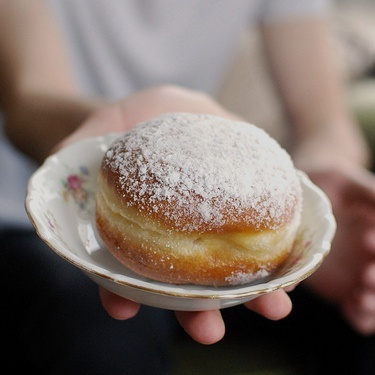

In [ ]:
from PIL import Image
from IPython.display import display

# Check if there are any images in the dictionary
if image_session_info:
    # Get the first image path in the dictionary
    first_image_path = next(iter(image_session_info))

    # Open and display the image
    image = Image.open(first_image_path)
    display(image)
else:
    print("No images found in the dictionary.")

### **Get stimulus/images representations using Taskonomy**

Taskonomy models can be loaded using the visualpriors python package, which provides a simple interface to get task representations for the 25 Taskonomy tasks. Be careful to provide the image in the format that [visualpriors](https://github.com/alexsax/midlevel-reps/blob/master/README.md#installing-visualpriors) expects (normalized between [-1, 1], and of size [3, 256, 256]). The output representations should be of size [C, H, W ], C = 8, H = W = 16; simply flatten them to create vector representations.


In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF
import visualpriors

def process_image(image_path, feature_type='normal', device='cpu'):
    image = Image.open(image_path).convert('RGB')
    transformed_image = TF.to_tensor(TF.resize(image, 256)) * 2 - 1  # Rescale to [-1, 1] and resize
    transformed_image = transformed_image.unsqueeze_(0)  # Add batch dimension
    representation = visualpriors.representation_transform(transformed_image, feature_type, device=device)
    flattened_representation = representation.view(representation.size(0), -1)
    return flattened_representation

In [ ]:
# TEST: Extract representations for the first image and exclude those that do not work
"""
# Example feature type (can be changed as needed)
feature_types_full = [
    "autoencoding", "depth_euclidean", "jigsaw", "reshading",
    "colorization", "edge_occlusion", "keypoints2d", "room_layout",
    "curvature", "edge_texture", "keypoints3d", "segment_unsup2d",
    "class_object", "egomotion", "nonfixated_pose", "segment_unsup25d",
    "class_scene", "fixated_pose", "normal", "segment_semantic",
    "denoising", "inpainting", "point_matching", "vanishing_point"]

# Process and store representations for all feature types
first_image_path = next(iter(image_session_info))
first_image_session = image_session_info[first_image_path]['session']
all_representations = {}

for feature_type in feature_types_full:
    try:
        representation = process_image(first_image_path, feature_type=feature_type)
        all_representations[feature_type] = representation
    except RuntimeError as e:
        print(f"Error processing {feature_type}: {e}")

# Update the dictionary
image_session_info[first_image_path] = {
    'session': first_image_session,
    'representations': all_representations}

# Print a summary
print(f"Image: {first_image_path}\nSession: {first_image_session}\nRepresentations:")
for feature_type, representation in all_representations.items():
    print(f"  Feature Type: {feature_type}\n  Representation: {representation}\n")
"""

In [ ]:
# Test again for just one image

# Final feature types
feature_types = ["depth_euclidean", "jigsaw", "edge_occlusion", "keypoints2d", "room_layout",
                 "segment_unsup2d", "class_object", "egomotion", "nonfixated_pose", "segment_unsup25d",
                 "class_scene", "fixated_pose", "normal", "segment_semantic", "denoising",
                 "inpainting", "point_matching", "vanishing_point", "class_object"] # or without "class_object"

# Process and store representations for all feature types
first_image_path = next(iter(image_session_info))
first_image_session = image_session_info[first_image_path]['session']

all_representations = {}

for feature_type in feature_types:
    try:
        representation = process_image(first_image_path, feature_type=feature_type)
        all_representations[feature_type] = representation
    except RuntimeError as e:
        print(f"Error processing {feature_type}: {e}")

# Update the dictionary
image_session_info[first_image_path]['representations'] = all_representations

In [ ]:
import itertools

# Show the first two entries of the dictionary
first_two_entries = itertools.islice(image_session_info.items(), 2)
for path, info in first_two_entries:
    print(f"Image Path: {path}\nSession: {info['session']}\nRepresentations:")
    for feature_type, representation in info['representations'].items():
        print(f"  Feature Type: {feature_type}\n  Representation: {representation}\n")
    print("\n")  # Add a new line for better readability between entries

In [ ]:
# Get representations for all images

# Iterate over all images in the dictionary
for image_path in image_session_info.keys():
    session_info = image_session_info[image_path]
    all_representations = {}

    # Process each feature type
    for feature_type in feature_types:
        try:
            representation = process_image(image_path, feature_type=feature_type)
            all_representations[feature_type] = representation
        except RuntimeError as e:
            print(f"Error processing {feature_type} for {image_path}: {e}")

    # Update the dictionary with representations for this image
    image_session_info[image_path]['representations'] = all_representations

    # Optional: Print a progress update
    print(f"Processed {image_path}")

In [ ]:
# Save the results on the drive (17 representations)

import pickle
import os

# Create the directory if it doesn't exist
save_dir = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/stimuli-representation"
os.makedirs(save_dir, exist_ok=True)

# File path for the pickle file
save_path = os.path.join(save_dir, 'image_session_info_17_repr.pkl')

# Saving the dictionary to a pickle file
with open(save_path, 'wb') as file:
    pickle.dump(image_session_info, file)
print(f"Data saved to {save_path}")

Data saved to /content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/stimuli-representation/image_session_info_17_repr.pkl


In [ ]:
# Loading the results back from the drive

# Create the directory if it doesn't exist
save_dir = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/stimuli-representation"
os.makedirs(save_dir, exist_ok=True)

# File path for the pickle file
save_path = os.path.join(save_dir, 'image_session_info_18_repr.pkl')

with open(save_path, 'rb') as file:
    stimuli_representation = pickle.load(file)

print("Data loaded successfully.")

Data loaded successfully.


In [ ]:
from torch.nn.functional import pad

# Determine the maximum size for each representation type
max_sizes = {feature_type: 0 for feature_type in feature_types}
for _, info in stimuli_representation.items():
    for feature_type, representation in info['representations'].items():
        max_sizes[feature_type] = max(max_sizes[feature_type], representation.numel())

# Pad the representations to the maximum size
for image_path, info in stimuli_representation.items():
    for feature_type, representation in info['representations'].items():
        target_size = max_sizes[feature_type]
        # Calculate padding
        padding = target_size - representation.numel()
        # Pad the tensor if it is not the maximum size
        if padding > 0:
            # Calculate padding for the last dimension
            pad_last_dim = (0, padding)
            # Pad the tensor and assign it back to the dictionary
            info['representations'][feature_type] = pad(representation, pad_last_dim, "constant", 0)

save_dir = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/stimuli-representation"
save_path = os.path.join(save_dir, 'image_session_info_18_repr_padded.pkl')

# Save the padded stimuli representations back to the pickle file
with open(save_path, 'wb') as file:
    pickle.dump(stimuli_representation, file)

print("Data padded and saved successfully.")

Data padded and saved successfully.


## **Problem 1: RSA and stimulus dependence**

We have previously been introduced to RSA as a simple means of comparing multiple representation spaces. Specifically, for a set of K Taskonomy networks, we can compute K RDM matrices on bold5000 stimuli data and produce K2 pairwise similarities to fill an RSA matrix.

### **Task 1: Compute and plot the RSA matrix**

Compute and plot this RSA matrix. How does it compare to the raw similarity matrix for encoding performance similarities reported in Fig 6 of Neural Taskonomy?

In [ ]:
# Loading the results back from the drive

# Create the directory if it doesn't exist
save_dir = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli-representation"
os.makedirs(save_dir, exist_ok=True)

# File path for the pickle file
save_path = os.path.join(save_dir, 'image_session_info_18_repr_padded.pkl')

with open(save_path, 'rb') as file:
    stimuli_representation = pickle.load(file)

print("Data loaded successfully.")

Data loaded successfully.


In [ ]:
import numpy as np
import pickle
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Function to compute the RDM
def compute_rdm(representations):
    # Assuming representations is a list of tensors
    max_size = max([rep.numel() for rep in representations])  # Find the maximum size of tensor
    padded_reps = [np.pad(rep.numpy().flatten(), (0, max_size - rep.numel()), 'constant') for rep in representations]
    rdm = np.corrcoef(padded_reps)
    # Since we want dissimilarity, subtract correlations from 1
    rdm = 1 - rdm
    return rdm

# Get feature types from the representations
feature_types = list(next(iter(stimuli_representation.values()))['representations'].keys())
feature_types

['depth_euclidean',
 'jigsaw',
 'edge_occlusion',
 'keypoints2d',
 'room_layout',
 'segment_unsup2d',
 'class_object',
 'egomotion',
 'nonfixated_pose',
 'segment_unsup25d',
 'class_scene',
 'fixated_pose',
 'normal',
 'segment_semantic',
 'denoising',
 'inpainting',
 'point_matching',
 'vanishing_point']

In [ ]:
# Compute RDMs and RSA matrix

"""
# Compute RDMs for each feature type with status bar
rdms = {}
for feature_type in tqdm(feature_types, desc="Computing RDMs"):
    rdms[feature_type] = compute_rdm([info['representations'][feature_type] for _, info in stimuli_representation.items()])

# Compute the RSA matrix with status bar
rsa_matrix = np.zeros((len(rdms), len(rdms)))
for i, ft_i in enumerate(tqdm(feature_types, desc="Computing RSA matrix")):
    for j, ft_j in enumerate(feature_types):
        rsa_matrix[i, j] = np.corrcoef(rdms[ft_i].flatten(), rdms[ft_j].flatten())[0, 1]

# Save rdms and rsa_matrix on drive

# Save the RDMs and RSA matrix to a pickle file
save_dir = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/stimuli-representation"
rdms_save_path = os.path.join(save_dir, 'rdms.pkl')
rsa_matrix_save_path = os.path.join(save_dir, 'rsa_matrix.pkl')

# Save the RDMs
with open(rdms_save_path, 'wb') as f:
    pickle.dump(rdms, f)

# Save the RSA matrix
with open(rsa_matrix_save_path, 'wb') as f:
    pickle.dump(rsa_matrix, f)
"""

In [ ]:
# Reopen rdms and rsa_matrix

save_dir = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli-representation"
os.makedirs(save_dir, exist_ok=True)
rdms_save_path = os.path.join(save_dir, 'rdms.pkl')
rsa_matrix_save_path = os.path.join(save_dir, 'rsa_matrix.pkl')

with open(rdms_save_path, 'rb') as file:
    rdms = pickle.load(file)
print("Data loaded successfully.")

with open(rsa_matrix_save_path, 'rb') as file:
    rsa_matrix = pickle.load(file)
print("Data loaded successfully.")

Data loaded successfully.
Data loaded successfully.


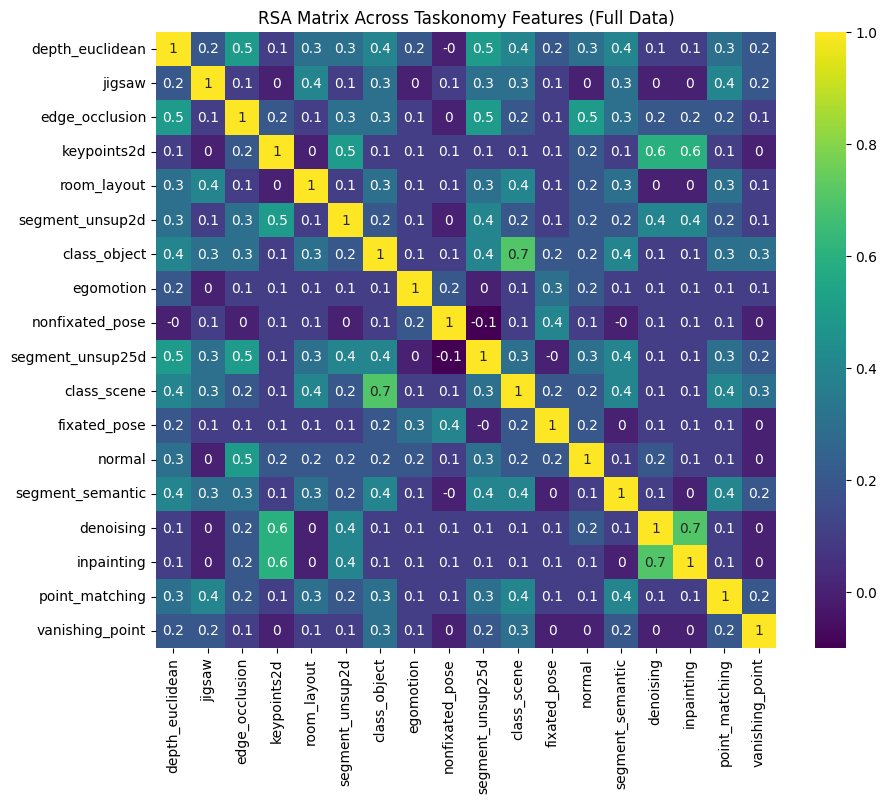

In [ ]:
# Plot the RSA matrix
rounded_rsa_matrix = np.round(rsa_matrix, 1)
rounded_rsa_matrix
plt.figure(figsize=(10, 8))
sns.heatmap(rounded_rsa_matrix, xticklabels=feature_types, yticklabels=feature_types, cmap='viridis', annot=True)
plt.title('RSA Matrix Across Taskonomy Features (Full Data)')
plt.show()

### **Task 2: Derive a task tree**

Derive a task tree from this matrix based on agglomerative clustering. Use “average“ linking. You may use [Neural Taskonomy code](https://github.com/ariaaay/NeuralTaskonomy/blob/master/code/make_task_tree.py) as a reference. Is this tree more similar to the original taskonomy or the neural taskonomy tree, and why?

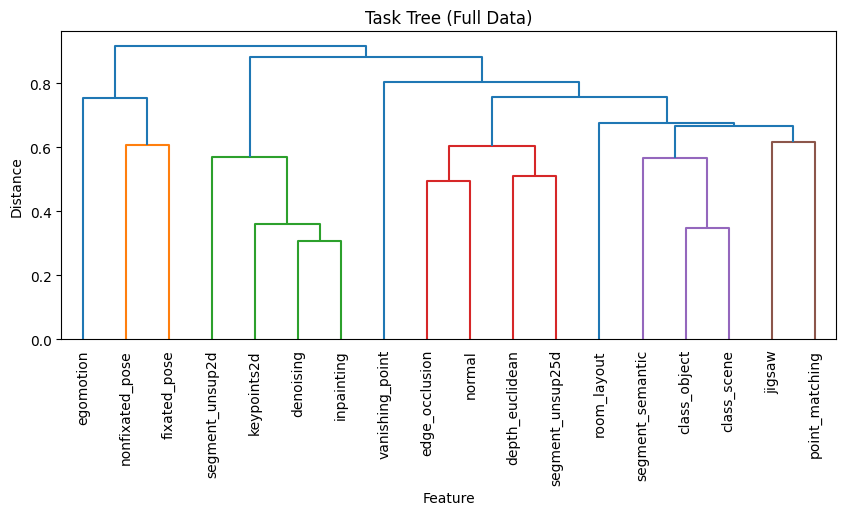

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform
import numpy as np

# Assuming rsa_matrix is the RSA matrix you obtained earlier
# Ensure the matrix is symmetric
sym_distance_matrix = (1 - rsa_matrix + (1 - rsa_matrix).T) / 2

# Check for NaN values and handle them if any
if np.isnan(sym_distance_matrix).any():
    sym_distance_matrix = np.nan_to_num(sym_distance_matrix)  # Replace NaNs with 0

# Ensure the diagonal is zero
np.fill_diagonal(sym_distance_matrix, 0)

# Perform hierarchical/agglomerative clustering
Z = linkage(squareform(sym_distance_matrix), 'average')

# Plot the dendrogram
plt.figure(figsize=(10, 4))
dendrogram(
    Z,
    labels=feature_types,
    leaf_rotation=90,
    leaf_font_size=10,)

plt.title('Task Tree (Full Data)')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.show()

### **Task 3: Run the analysis on the subset of stimuli data**

Taskonomy networks are trained on indoor scenes, and Wang et al. report this distribution transfer affects the performance of Taskonomy models. Subset the stimuli data to only consider the stimuli from Scene Images (under Scene Stimuli/Presented Stimuli/Scene using Stimuli Presentation Lists, and repeat this analysis. How does the change in stimulus affect the resulting tree?

In [ ]:
import itertools

# Subset the data
"""
# The root directory where the stimuli are stored
stimuli_root = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/Scene_Stimuli/Presented_Stimuli/Scene/"

# Filter out only the Scene images
scene_stimuli_representation = {
    path: info for path, info in stimuli_representation.items() if path.startswith(stimuli_root)}

# Create a new save path for the filtered scene stimuli representations
scene_save_path = os.path.join(save_dir, 'scene_stimuli_representation.pkl')

# Save the filtered dictionary to a new pickle file
with open(scene_save_path, 'wb') as file:
    pickle.dump(scene_stimuli_representation, file)

print(f"Scene data saved to {scene_save_path}")
"""

Scene data saved to /content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/stimuli-representation/scene_stimuli_representation.pkl
Scene data loaded successfully.
Scene Image Path: /content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/Scene_Stimuli/Presented_Stimuli/Scene/garbagedump4.jpg
Session: CSI1_sess11

Scene Image Path: /content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/Scene_Stimuli/Presented_Stimuli/Scene/pharmacy.jpg
Session: CSI1_sess11



In [ ]:
# The root directory where the stimuli are stored
save_dir = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli-representation"
scene_save_path = os.path.join(save_dir, 'scene_stimuli_representation.pkl')

# Then reopen it
with open(scene_save_path, 'rb') as file:
    loaded_scene_stimuli_representation = pickle.load(file)

print("Scene data loaded successfully.")

# Test to verify that the filtered stimuli data contains only scene images
stimuli_root = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/Scene_Stimuli/Presented_Stimuli/Scene/"
assert all(path.startswith(stimuli_root) for path in loaded_scene_stimuli_representation), "Non-scene images found in the filtered data."

Scene data loaded successfully.


In [ ]:
# Compute and plot RSA matrix for the subset of data
"""
# Compute RDMs for each feature type with status bar
rdms_scene = {}
for feature_type in tqdm(feature_types, desc="Computing RDMs"):
    rdms_scene[feature_type] = compute_rdm([info['representations'][feature_type] for _, info in loaded_scene_stimuli_representation.items()])

# Compute the RSA matrix with status bar
rsa_matrix_scene = np.zeros((len(rdms_scene), len(rdms_scene)))
for i, ft_i in enumerate(tqdm(feature_types, desc="Computing RSA matrix")):
    for j, ft_j in enumerate(feature_types):
        rsa_matrix_scene[i, j] = np.corrcoef(rdms_scene[ft_i].flatten(), rdms_scene[ft_j].flatten())[0, 1]

# Save rdms and rsa_matrix on drive

# Save the RDMs and RSA matrix to a pickle file
save_dir = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/stimuli-representation"
rdms_save_path = os.path.join(save_dir, 'rdms_scene.pkl')
rsa_matrix_save_path = os.path.join(save_dir, 'rsa_matrix_scene.pkl')

# Save the RDMs
with open(rdms_save_path, 'wb') as f:
    pickle.dump(rdms_scene, f)

# Save the RSA matrix
with open(rsa_matrix_save_path, 'wb') as f:
    pickle.dump(rsa_matrix_scene, f)
"""

Computing RSA matrix: 100%|██████████| 18/18 [00:04<00:00,  4.25it/s]


Data loaded successfully.
Data loaded successfully.


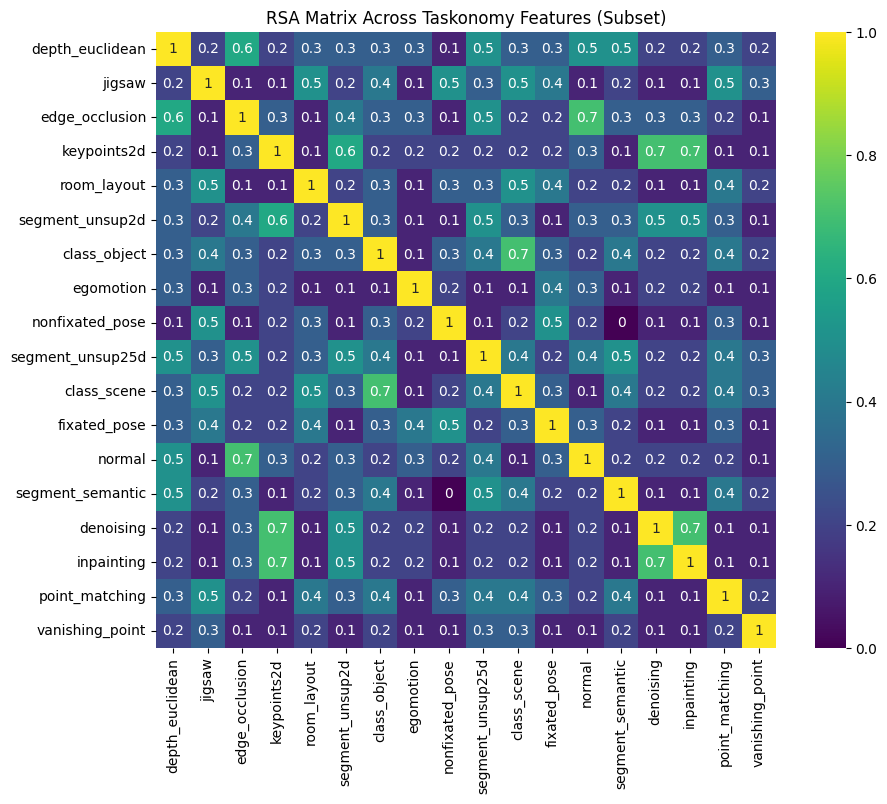

In [ ]:
# Reopen rdms and rsa_matrix

save_dir = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli-representation"
os.makedirs(save_dir, exist_ok=True)
rdms_save_path = os.path.join(save_dir, 'rdms_scene.pkl')
rsa_matrix_save_path = os.path.join(save_dir, 'rsa_matrix_scene.pkl')

with open(rdms_save_path, 'rb') as file:
    rdms_scene = pickle.load(file)
print("Data loaded successfully.")

with open(rsa_matrix_save_path, 'rb') as file:
    rsa_matrix_scene = pickle.load(file)
print("Data loaded successfully.")

# Plot the RSA matrix
rounded_rsa_matrix_scene = np.round(rsa_matrix_scene, 1)
plt.figure(figsize=(10, 8))
sns.heatmap(rounded_rsa_matrix_scene, xticklabels=feature_types, yticklabels=feature_types, cmap='viridis', annot=True)
plt.title('RSA Matrix Across Taskonomy Features (Subset)')
plt.show()

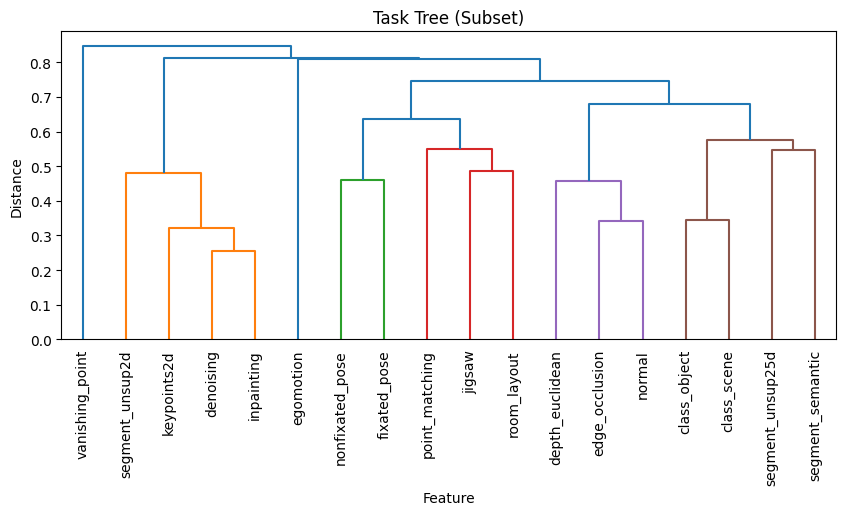

In [ ]:
# Derive a task tree

# Assuming rsa_matrix is the RSA matrix you obtained earlier
# Ensure the matrix is symmetric
sym_distance_matrix = (1 - rsa_matrix_scene + (1 - rsa_matrix_scene).T) / 2

# Check for NaN values and handle them if any
if np.isnan(sym_distance_matrix).any():
    sym_distance_matrix = np.nan_to_num(sym_distance_matrix)  # Replace NaNs with 0

# Ensure the diagonal is zero
np.fill_diagonal(sym_distance_matrix, 0)

# Perform hierarchical/agglomerative clustering
Z = linkage(squareform(sym_distance_matrix), 'average')

# Plot the dendrogram
plt.figure(figsize=(10, 4))
dendrogram(
    Z,
    labels=feature_types,
    leaf_rotation=90,
    leaf_font_size=10,)

plt.title('Task Tree (Subset)')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.show()

## **Problem 2: Testing an asymmetric distance**

Note that at this point, no neural data has been used. Moving forward, restrict your analysis to the neural data where scene stimuli was presented.

In the first HW we considered how different contexts and layers of a single language model produced different representations for encoding models. Taskonomy more clearly specifies encoding model hypotheses by using the same layer in the same network, but trained under different objectives.


In [ ]:
# Align the shapes between fMRI data and image representations

# We have 15 sessions, in each session participants viewed images in certain order
# There is a different number of images per session

# fMRI data --> 15 sessions/files --> each session/file shape -> (num_train_images, 1666 voxels) -->
#### --> this can be organized in the dictionary -->
#### --> a dict of key: session_number, value: fMRI data of the shape (num_train_images, 1666 voxels)

# Image embeddings --> 15 sessions --> each has multiple runs --> each run lists an order of images shown -->
#### --> for each image we create 18 different types of embeddings/features of the shape (1 , 2304 features) -->
#### --> this can be organized in the dictionary -->
#### --> a dict of key: session_number, value: {feature type: embeddings data of the shape (num_train_images, 2304 features)}

## Then I can easily run the ridge regression for each feature type.
## where my X is Image embeddings (num_train_images, 2304 features) and Y = fMRI data (num_train_images, 1666 voxels)

In [12]:
import numpy as np
import nibabel as nib
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
from sklearn.metrics import make_scorer
from tqdm import tqdm
import os
import glob

# Directory paths and constants
DATA_DIR = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/"
STIMULI_REPR_PATH = DATA_DIR + "stimuli-representation"
STIMULI_REPR_PATH_PADDED = DATA_DIR + "stimuli-representation/image_session_info_18_repr_padded.pkl"
STIMULI_REPR_PATH_NON_PADDED = DATA_DIR + "stimuli-representation/image_session_info_18_repr.pkl"
FMRI_DATA_DIR = DATA_DIR + "fmri-data/"
MASK_DIR = DATA_DIR + "brain-mask-sub-CSI1"

### **Task 0: Align fMRI and stimulus data**

**fMRI data**

In [ ]:
# Get fMRI data
!ls drive/MyDrive/'10733 - Neuro and AI'/homework2/fmri-data

# Get mask data (wil create a union of it and apply to the fMRI data)
!ls drive/MyDrive/'10733 - Neuro and AI'/homework2/brain-mask-sub-CSI1

CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-02.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-03.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-04.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-05.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-06.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-07.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-08.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-09.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-10.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-11.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-12.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-13.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-14.nii.gz
CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-15.nii.gz
fmri_session_data.pkl
MD5E-s702--ffcd5c3f53b54cbc8a945315e13ce242.nii.gz
MD5E-s711--6d94892113e8ad6f96016bf6b61743f2.nii.gz
MD5E-s745--2aa24a1e604362d8a874b47220e78dd9.nii.gz


In [ ]:
# Load masks and create a union mask
mask_files = glob.glob(MASK_DIR + "/" + '*.nii.gz')
union_mask = None
for mask_file in mask_files:
    mask_data = nib.load(mask_file).get_fdata().astype(bool)
    if union_mask is None:
        union_mask = mask_data
    else:
        union_mask = np.logical_or(union_mask, mask_data)

# Check the union mask
print(f"Union mask shape: {union_mask.shape}")
print(f"Number of voxels in the mask: {union_mask.sum()}")

# Function to extract session number from fMRI file name
def extract_session_number(fmri_file_name):
    # Example file format: 'CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz'
    # Extracting the part after 'ses-' and before '.nii.gz'
    session_number = fmri_file_name.split('_ses-')[-1].split('.nii.gz')[0]
    return 'CSI1_sess' + session_number

# Load and mask fMRI data
fmri_files = sorted(glob.glob(FMRI_DATA_DIR + '*.nii.gz'))

# Dictionary to store fMRI data by session
fmri_session_data = {}

for fmri_file in fmri_files:
    session_number = extract_session_number(fmri_file)
    fmri_data = nib.load(fmri_file).get_fdata() # Load the fMRI data
    masked_data = fmri_data[union_mask]
    masked_data = masked_data.T # Transpose the data to match the format (num_images, num_voxels)
    fmri_session_data[session_number] = masked_data
    print(f"Session {session_number}, Masked data shape: {masked_data.shape}")

# SHAPES: Union mask shape (71, 89, 72) --> (X, Y, Z axes)
# SHAPES: Masked data shape (1666, number of images) # of stimuli/images varies by session

Union mask shape: (71, 89, 72)
Number of voxels in the mask: 1666
Session CSI1_sess01, Masked data shape: (370, 1666)
Session CSI1_sess02, Masked data shape: (370, 1666)
Session CSI1_sess03, Masked data shape: (370, 1666)
Session CSI1_sess04, Masked data shape: (333, 1666)
Session CSI1_sess05, Masked data shape: (370, 1666)
Session CSI1_sess06, Masked data shape: (333, 1666)
Session CSI1_sess07, Masked data shape: (370, 1666)
Session CSI1_sess08, Masked data shape: (333, 1666)
Session CSI1_sess09, Masked data shape: (333, 1666)
Session CSI1_sess10, Masked data shape: (370, 1666)
Session CSI1_sess11, Masked data shape: (333, 1666)
Session CSI1_sess12, Masked data shape: (333, 1666)
Session CSI1_sess13, Masked data shape: (333, 1666)
Session CSI1_sess14, Masked data shape: (333, 1666)
Session CSI1_sess15, Masked data shape: (370, 1666)


In [ ]:
import pickle
import os

# Ensure the directory exists
os.makedirs(FMRI_DATA_DIR, exist_ok=True)

# Define the file path for saving
fmri_data_file_path = os.path.join(FMRI_DATA_DIR, 'fmri_session_data.pkl')

# Save fmri_session_data to the file
with open(fmri_data_file_path, 'wb') as file:
    pickle.dump(fmri_session_data, file)

print(f"fmri_session_data saved to {fmri_data_file_path}")

fmri_session_data saved to /content/drive/MyDrive/10733 - Neuro and AI/homework2/fmri-data/fmri_session_data.pkl


**Stimuli (images) data**

In [ ]:
# Check for inconsistency in shapes
## RESULT
## Regular shape: [1, 2048]
## Two inconsistent images: childsroom7.jpg [1, 2176] and golfcourse7.jpg [1, 2304]
## Just pad to the max.

"""
import pickle
# Load the stimuli representations
with open(STIMULI_REPR_PATH_NON_PADDED, 'rb') as file:
    stimuli_representation_non_padded = pickle.load(file)

print("Total items in stimuli_representation_non_padded:", len(stimuli_representation_non_padded))

feature_shapes = {}

# Check the shapes of representations
consistent_shapes = True
for image_path, image_info in stimuli_representation_non_padded.items():
    for feature_type, representation in image_info['representations'].items():
        # Initialize the shape for this feature type if not already done
        if feature_type not in feature_shapes:
            feature_shapes[feature_type] = representation.shape
        # Compare the current shape with the stored shape
        elif feature_shapes[feature_type] != representation.shape:
            print(f"Shape mismatch in feature '{feature_type}' for image '{image_path}'.")
            print(f"Image '{image_path}', Representation '{representation.shape}'")
            consistent_shapes = False

# Print the result
if consistent_shapes:
    print("All features have consistent shapes across all images.")
else:
    print("There are inconsistencies in feature shapes.")
"""

In [ ]:
import pickle

# Load the stimuli representations
with open(STIMULI_REPR_PATH_PADDED, 'rb') as file:
    stimuli_representation_padded = pickle.load(file)

In [ ]:
# Print the total number of items in the dictionary
print("Total items in stimuli_representation_padded:", len(stimuli_representation_padded))

# Iterate over the dictionary and print the key structure and a sample of its values
for i, (image_path, image_info) in enumerate(stimuli_representation_padded.items()):
    print("\nimage path:", image_path)
    print("session:", image_info['session'])
    print("representations:")

    for feature_type, representation in image_info['representations'].items():
        print(f"  feature_type: {feature_type}")
        print(f"  representation shape and sample values: {representation.shape}, {representation[:2]}")

    # Limiting the output for readability
    if i == 2:  # Change this number to view more items
        break

In [ ]:
import os
import numpy as np
import pickle

# Function to read the image order from text files
def read_image_order(session_dir):
    image_order = []
    for run_file in sorted(os.listdir(session_dir)):
        if run_file.endswith('.txt'):
            with open(os.path.join(session_dir, run_file), 'r') as file:
                images = [line.strip() for line in file]
                image_order.extend(images)
    return image_order

def map_image_name_to_path(image_name, stimuli_representation):

    if image_name.startswith('rep_'): # Remove 'rep_' prefix from repeated images to match the original image name
        image_name = image_name[4:]

    for path in stimuli_representation:
        if image_name in path:
            return path
    return None

# Directory containing the session image order files
presentation_lists_dir = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli/Stimuli_Presentation_Lists/CSI1"

# Organize stimuli representations for each session
stimuli_session_data = {}
for session_number in range(1, 16):  # Assuming 15 sessions
    session_name = f'CSI1_sess{session_number:02d}'
    session_dir = os.path.join(presentation_lists_dir, session_name)

    # Read the image order for the session
    image_order = read_image_order(session_dir)

    # Create an array for each feature type with the representations in correct order
    session_features = {feature_type: [] for feature_type in stimuli_representation_padded[next(iter(stimuli_representation_padded))]['representations']}

    for image_name in image_order:
        full_path = map_image_name_to_path(image_name, stimuli_representation_padded)
        if full_path:
            for feature_type, representation in stimuli_representation_padded[full_path]['representations'].items():
                session_features[feature_type].append(representation)
        else:
            print(f"Image not found in stimuli_representation for {image_name}")

    for feature_type in session_features:
        session_features[feature_type] = np.array(session_features[feature_type]).reshape(-1, 2304)  # Reshape to (num_images, num_features)

    stimuli_session_data[session_name] = session_features

In [ ]:
# Ensure the directory exists
os.makedirs(STIMULI_REPR_PATH, exist_ok=True)

# Define the file path for saving
stimuli_data_file_path = os.path.join(STIMULI_REPR_PATH, 'stimuli_session_data.pkl')

# Save stimuli_session_data to the file
with open(stimuli_data_file_path, 'wb') as file:
    pickle.dump(stimuli_session_data, file)

print(f"stimuli_session_data saved to {stimuli_data_file_path}")

stimuli_session_data saved to /content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli-representation/stimuli_session_data.pkl


**Check the final shapes**

In [ ]:
# Iterate through each session and compare the shapes
for session_name in fmri_session_data:
    fmri_shape = fmri_session_data[session_name].shape
    stimuli_shape = {feature_type: stimuli_session_data[session_name][feature_type].shape for feature_type in stimuli_session_data[session_name]}

    print(f"Session: {session_name}")
    print(f"  fMRI data shape: {fmri_shape}")

    for feature_type in stimuli_shape:
        print(f"  Stimuli {feature_type} data shape: {stimuli_shape[feature_type]}")

Session: CSI1_sess01
  fMRI data shape: (370, 1666)
  Stimuli depth_euclidean data shape: (370, 2304)
  Stimuli jigsaw data shape: (370, 2304)
  Stimuli edge_occlusion data shape: (370, 2304)
  Stimuli keypoints2d data shape: (370, 2304)
  Stimuli room_layout data shape: (370, 2304)
  Stimuli segment_unsup2d data shape: (370, 2304)
  Stimuli class_object data shape: (370, 2304)
  Stimuli egomotion data shape: (370, 2304)
  Stimuli nonfixated_pose data shape: (370, 2304)
  Stimuli segment_unsup25d data shape: (370, 2304)
  Stimuli class_scene data shape: (370, 2304)
  Stimuli fixated_pose data shape: (370, 2304)
  Stimuli normal data shape: (370, 2304)
  Stimuli segment_semantic data shape: (370, 2304)
  Stimuli denoising data shape: (370, 2304)
  Stimuli inpainting data shape: (370, 2304)
  Stimuli point_matching data shape: (370, 2304)
  Stimuli vanishing_point data shape: (370, 2304)
Session: CSI1_sess02
  fMRI data shape: (370, 1666)
  Stimuli depth_euclidean data shape: (370, 2304)

**Concatenate the info across all sessions**

In [ ]:
# Initialize empty lists to store concatenated data
all_fmri_data = []
all_stimuli_data = {feature_type: [] for feature_type in stimuli_session_data[next(iter(stimuli_session_data))]}

########################## fMRI ##########################

# Iterate through each session
for session_name in fmri_session_data:
    # Extract fMRI data for the current session
    fmri_data = fmri_session_data[session_name]
    # Append it to the list of all fMRI data
    all_fmri_data.append(fmri_data)

    # Extract stimuli data for the current session
    stimuli_data_session = stimuli_session_data[session_name]
    for feature_type in stimuli_data_session:
        # Append the stimuli data for the current feature type to the corresponding list
        all_stimuli_data[feature_type].append(stimuli_data_session[feature_type])

# Concatenate the fMRI data across all sessions
all_fmri_data = np.concatenate(all_fmri_data, axis=0)

# Save
os.makedirs(FMRI_DATA_DIR, exist_ok=True)
fmri_data_file_path = os.path.join(FMRI_DATA_DIR, 'all_fmri_data.pkl')
with open(fmri_data_file_path, 'wb') as file:
    pickle.dump(all_fmri_data, file)
print(f"fmri_session_data saved to {fmri_data_file_path}")

########################## Stimuli ##########################

# Concatenate the stimuli data across all sessions for each feature type
for feature_type in all_stimuli_data:
    all_stimuli_data[feature_type] = np.concatenate(all_stimuli_data[feature_type], axis=0)

os.makedirs(STIMULI_REPR_PATH, exist_ok=True)
stimuli_data_file_path = os.path.join(STIMULI_REPR_PATH, 'all_stimuli_data.pkl')
with open(stimuli_data_file_path, 'wb') as file:
    pickle.dump(all_stimuli_data, file)

print(f"stimuli_session_data saved to {stimuli_data_file_path}")

########################## See the results ##########################

# Print the shapes of the concatenated data
print("Concatenated fMRI data shape:", all_fmri_data.shape)
for feature_type in all_stimuli_data:
    print(f"Concatenated {feature_type} data shape:", all_stimuli_data[feature_type].shape)

fmri_session_data saved to /content/drive/MyDrive/10733 - Neuro and AI/homework2/fmri-data/all_fmri_data.pkl
stimuli_session_data saved to /content/drive/MyDrive/10733 - Neuro and AI/homework2/stimuli-representation/all_stimuli_data.pkl
Concatenated fMRI data shape: (5254, 1666)
Concatenated depth_euclidean data shape: (5254, 2304)
Concatenated jigsaw data shape: (5254, 2304)
Concatenated edge_occlusion data shape: (5254, 2304)
Concatenated keypoints2d data shape: (5254, 2304)
Concatenated room_layout data shape: (5254, 2304)
Concatenated segment_unsup2d data shape: (5254, 2304)
Concatenated class_object data shape: (5254, 2304)
Concatenated egomotion data shape: (5254, 2304)
Concatenated nonfixated_pose data shape: (5254, 2304)
Concatenated segment_unsup25d data shape: (5254, 2304)
Concatenated class_scene data shape: (5254, 2304)
Concatenated fixated_pose data shape: (5254, 2304)
Concatenated normal data shape: (5254, 2304)
Concatenated segment_semantic data shape: (5254, 2304)
Conca

### **Task 1: Encoding model for fMRI response prediction**

Use each of the Taskonomy representations from part 1 to build an encoding model to predict subject CSI1’s fmri response to images in the bold5000 dataset. Replicate figure 6 from the Neural Taskonomy paper for a CSI1 (not averaged across subjects like in the paper) to get a similarity matrix for the representations that different tasks share in predicting the brain. Note that in this problem you should follow the same procedure as the neural taskonomy paper: fit each model, calculate the correlation, drop the non-predictive voxels according to the p-value of a permutation test on the correlation. So you should end up with a correlation matrix of size T by M where T is the number of tasks and M is the number of selected voxels. Then calculate the dot product between each of these representations to form your similarity matrix.

**Deliver**: Show your similarity matrix plot in your pdf.


In [13]:
# Load the fMRI data
fmri_data_file_path = os.path.join(FMRI_DATA_DIR, 'all_fmri_data.pkl')
with open(fmri_data_file_path, 'rb') as file:
    all_fmri_data = pickle.load(file)

# Load the stimulus data
stimuli_data_file_path = os.path.join(STIMULI_REPR_PATH, 'all_stimuli_data.pkl')
with open(stimuli_data_file_path, 'rb') as file:
    all_stimuli_data = pickle.load(file)

# Print the shapes of the concatenated data
print("Concatenated fMRI data shape:", all_fmri_data.shape)
for feature_type in all_stimuli_data:
    print(f"Concatenated {feature_type} data shape:", all_stimuli_data[feature_type].shape)

Concatenated fMRI data shape: (5254, 1666)
Concatenated depth_euclidean data shape: (5254, 2304)
Concatenated jigsaw data shape: (5254, 2304)
Concatenated edge_occlusion data shape: (5254, 2304)
Concatenated keypoints2d data shape: (5254, 2304)
Concatenated room_layout data shape: (5254, 2304)
Concatenated segment_unsup2d data shape: (5254, 2304)
Concatenated class_object data shape: (5254, 2304)
Concatenated egomotion data shape: (5254, 2304)
Concatenated nonfixated_pose data shape: (5254, 2304)
Concatenated segment_unsup25d data shape: (5254, 2304)
Concatenated class_scene data shape: (5254, 2304)
Concatenated fixated_pose data shape: (5254, 2304)
Concatenated normal data shape: (5254, 2304)
Concatenated segment_semantic data shape: (5254, 2304)
Concatenated denoising data shape: (5254, 2304)
Concatenated inpainting data shape: (5254, 2304)
Concatenated point_matching data shape: (5254, 2304)
Concatenated vanishing_point data shape: (5254, 2304)


In [128]:
# Calculate correlations
def corr(x, y):
    x_centered = x - np.mean(x)
    y_centered = y - np.mean(y)
    return np.dot(x_centered, y_centered) / (np.linalg.norm(x_centered) * np.linalg.norm(y_centered))

correlations = {feature_type: [] for feature_type in all_stimuli_data}
predictions_dict = {feature_type: None for feature_type in all_stimuli_data}

for feature_type in tqdm(all_stimuli_data, desc='Calculating Correlations'):
    X = all_stimuli_data[feature_type]
    Y = all_fmri_data
    model = Ridge(alpha=10000)
    model.fit(X, Y)
    predictions = model.predict(X)
    predictions_dict[feature_type] = predictions
    corr_vals = [corr(predictions[:, i], Y[:, i]) for i in range(Y.shape[1])]
    correlations[feature_type].extend(corr_vals)

Calculating Correlations: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


In [15]:
# Print type, shape, and sample of 2 from correlations dictionary
for feature_type, values in correlations.items():
    print(f"Feature Type: {feature_type}, Shape: {len(values)}, Sample of Correlations: {values[:2]}")

# Correlation between predicted_fMRI and true_fMRI for each of 1666 voxels

Feature Type: depth_euclidean, Shape: 1666, Sample of Correlations: [0.3942185091800198, 0.41015133692564004]
Feature Type: jigsaw, Shape: 1666, Sample of Correlations: [0.21010208543547398, 0.23244622945391907]
Feature Type: edge_occlusion, Shape: 1666, Sample of Correlations: [0.45677443023937603, 0.47522666201719427]
Feature Type: keypoints2d, Shape: 1666, Sample of Correlations: [0.5036740447656252, 0.49122077966121996]
Feature Type: room_layout, Shape: 1666, Sample of Correlations: [0.23866698042234916, 0.29627666555196136]
Feature Type: segment_unsup2d, Shape: 1666, Sample of Correlations: [0.44453116630019673, 0.4347394981700147]
Feature Type: class_object, Shape: 1666, Sample of Correlations: [0.2764013976802788, 0.3586317105443405]
Feature Type: egomotion, Shape: 1666, Sample of Correlations: [0.3923310457490654, 0.4069456255033507]
Feature Type: nonfixated_pose, Shape: 1666, Sample of Correlations: [0.26185258665916483, 0.27359810719884436]
Feature Type: segment_unsup25d, Sha

In [16]:
# Calculate how significant is the correlation between predicted_fMRI and true_fMRI for each of 1666 voxels
# Permutation test is performed for each voxel independently

def single_voxel_permutation_test(voxel_prediction, voxel_response, shuffles=5):
    '''Performs a permutation test against the null hypothesis that
       model responses to stimulus do not predict voxel responses to that stimulus'''
    model_corr = corr(voxel_prediction, voxel_response)
    g_than_model_corr_counts = 0
    copy_response = np.copy(voxel_response)
    for _ in range(shuffles):
        np.random.shuffle(copy_response)
        c = corr(voxel_prediction, copy_response)
        if c > model_corr:
            g_than_model_corr_counts += 1
    return g_than_model_corr_counts / shuffles

# Perform permutation test and FDR correction
p_values = {feature_type: [] for feature_type in correlations}

for feature_type in tqdm(correlations, desc='Permutation Test'):

    X = all_stimuli_data[feature_type]  # Stimuli data for the current feature type
    Y = all_fmri_data.T  # All fMRI data --> (1666, 5254)

    for i in range(Y.shape[0]): # Loop over each voxel
        voxel_predictions = correlations[feature_type]  # Predictions for a single voxel and feature type
        voxel_responses = Y[:, i]  # Responses for a single voxel
        p_val = single_voxel_permutation_test(voxel_predictions, voxel_responses)
        p_values[feature_type].append(p_val)

# Check the length
for feature_type, indices in p_values.items():
    print(f"Feature Type: {feature_type}, Shape: {len(indices)}")

Permutation Test: 100%|██████████| 18/18 [00:45<00:00,  2.50s/it]

Feature Type: depth_euclidean, Shape: 1666
Feature Type: jigsaw, Shape: 1666
Feature Type: edge_occlusion, Shape: 1666
Feature Type: keypoints2d, Shape: 1666
Feature Type: room_layout, Shape: 1666
Feature Type: segment_unsup2d, Shape: 1666
Feature Type: class_object, Shape: 1666
Feature Type: egomotion, Shape: 1666
Feature Type: nonfixated_pose, Shape: 1666
Feature Type: segment_unsup25d, Shape: 1666
Feature Type: class_scene, Shape: 1666
Feature Type: fixated_pose, Shape: 1666
Feature Type: normal, Shape: 1666
Feature Type: segment_semantic, Shape: 1666
Feature Type: denoising, Shape: 1666
Feature Type: inpainting, Shape: 1666
Feature Type: point_matching, Shape: 1666
Feature Type: vanishing_point, Shape: 1666


In [19]:
# Get the most significant voxels
def fdr_corrected_significant_ps(ps, alpha):
    '''Returns the indices of ps that are significant under FDR correction'''
    sorted_ps = np.sort(ps)
    sorted_indices = np.argsort(ps)
    comparison = alpha * (1 + np.arange(len(sorted_ps))) / len(sorted_ps)
    return sorted_indices[sorted_ps < comparison]

significant_voxels = {feature_type: fdr_corrected_significant_ps(p_values[feature_type], 0.05) for feature_type in p_values}

# Check the number of significant voxels per feature type
for feature_type, indices in significant_voxels.items():
    print(f"Feature Type: {feature_type}, Shape: {len(indices)}")

Feature Type: depth_euclidean, Shape: 1630
Feature Type: jigsaw, Shape: 1502
Feature Type: edge_occlusion, Shape: 1634
Feature Type: keypoints2d, Shape: 1617
Feature Type: room_layout, Shape: 1454
Feature Type: segment_unsup2d, Shape: 1642
Feature Type: class_object, Shape: 1627
Feature Type: egomotion, Shape: 1627
Feature Type: nonfixated_pose, Shape: 1656
Feature Type: segment_unsup25d, Shape: 1644
Feature Type: class_scene, Shape: 1633
Feature Type: fixated_pose, Shape: 1501
Feature Type: normal, Shape: 1637
Feature Type: segment_semantic, Shape: 1623
Feature Type: denoising, Shape: 1603
Feature Type: inpainting, Shape: 1602
Feature Type: point_matching, Shape: 1630
Feature Type: vanishing_point, Shape: 1422


In [95]:
# Initialize correlation matrix with the shape (T, M)
selected_voxels_indices = {feature_type: significant_voxels[feature_type] for feature_type in significant_voxels}

T = len(selected_voxels_indices)  # Number of Taskonomy representations
M = max(len(indices) for indices in selected_voxels_indices.values())  # Maximum number of selected voxels
correlation_matrix = np.zeros((T, M))

# Compute correlations and fill the correlation matrix
"""
For each feature type (model representation), we iterate over the selected significant voxels.
For each voxel pair, we calculate the correlation between their responses to stimuli.
The correlations are stored in the correlation matrix, with each entry representing
the correlation between the responses of two specific voxels.
"""

# Compute correlations and fill the correlation matrix
for i, (feature_type, indices) in enumerate(selected_voxels_indices.items()):
    num_voxels = len(indices)
    for j in tqdm(range(num_voxels), desc=f'Feature: {feature_type}'):
        voxel_index_j = indices[j]
        for k in range(num_voxels):
            voxel_index_k = indices[k]
            correlation_matrix[i, j] += correlations[feature_type][voxel_index_j] * correlations[feature_type][voxel_index_k]

# Find the minimum and maximum values in the correlation matrix
min_corr = np.min(correlation_matrix)
max_corr = np.max(correlation_matrix)

# Normalize each entry in the correlation matrix between 0 and 1
correlation_matrix = (correlation_matrix - min_corr) / (max_corr - min_corr)

# Calculate the dot product between each of these representations to form the similarity matrix
"""
Once the correlation matrix is constructed, we calculate the dot product between the correlation matrix and its transpose.
This operation yields the similarity matrix, where each entry (i, j)
represents the similarity between the representations of voxel i and voxel j across different models.
"""
similarity_matrix = np.dot(correlation_matrix, correlation_matrix.T) / M

Feature: vanishing_point: 100%|██████████| 1422/1422 [00:01<00:00, 1034.39it/s]


In [111]:
print(correlation_matrix[0])
print()
print(similarity_matrix[0])

[0.61179779 0.63254554 0.66200809 ... 0.         0.         0.        ]

[1.         0.10049621 0.51125182 0.55713398 0.14015371 0.46575174
 0.23312241 0.36495434 0.16805286 0.39749573 0.22014781 0.15552736
 0.46012625 0.33593033 0.50075006 0.54513403 0.16436894 0.19473673]


In [112]:
CALCULATIONS = "/content/drive/MyDrive/10733 - Neuro and AI/homework2/calculations"
CORRELATION_PATH = os.path.join(CALCULATIONS, "correlation_matrix_v6.npy")
SIMILARITY_PATH = os.path.join(CALCULATIONS, "similarity_matrix_v6.npy")

# Save on the drive
np.save(CORRELATION_PATH, correlation_matrix)
np.save(SIMILARITY_PATH, similarity_matrix)

# Load back
correlation_matrix_loaded = np.load(CORRELATION_PATH)
similarity_matrix_loaded = np.load(SIMILARITY_PATH)

print('correlation_matrix_loaded', correlation_matrix_loaded.shape)
print('similarity_matrix_loaded', similarity_matrix_loaded.shape)

correlation_matrix_loaded (18, 1656)
similarity_matrix_loaded (18, 18)


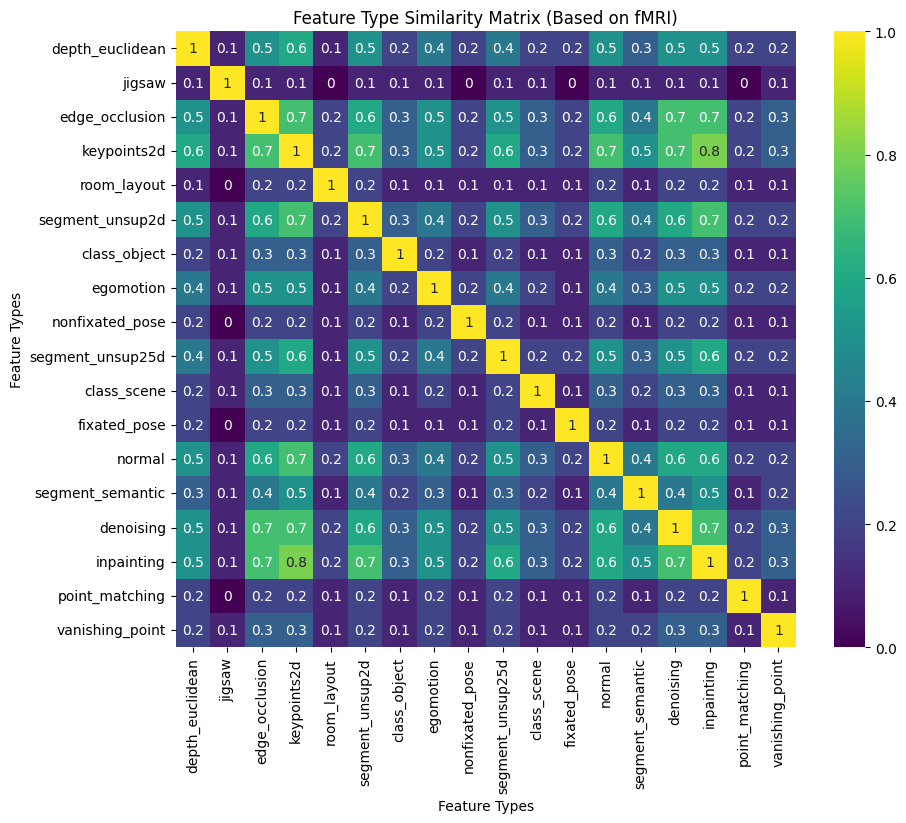

In [117]:
# Plot the similarity matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

similarity_matrix_loaded = np.round(similarity_matrix_loaded, 1)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_loaded, annot=True, xticklabels=feature_types, cmap='viridis', yticklabels=feature_types)
plt.title("Feature Type Similarity Matrix (Based on fMRI)")
plt.xlabel("Feature Types")
plt.ylabel("Feature Types")
plt.show()

### **Task 2: Symmetric model relationship analysis**

In this analysis, the relationship between how models represent the brain is symmetric since the similarity is a dot product on correlations over well predicted voxels.

**Deliver**: What does this analysis tell us about the models’ relationship with the brain? Due to its construction, what might this model not be able to tell us that other similarity relationships might?

In [ ]:
# See the written report.

### **Task 3: Asymmetric transfer and predictive power**

In figure 7 of the Taskonomy paper, they show that the transfer of models can be asymmetric. Model A might be able to successfully perform another model, B’s, task while B has an inability to perform Model A’s task successfully. We now want to explore whether a similar relationship in maintained in their ability to predict the brain. Does a model that transfers more succesfully to other tasks show better predictive power in the brain?

**Deliver**: Calculate the average R2 for five models across all the selected voxels in Q2.1. Do any of the models show higher/lower average R2 compared to the others?

In [138]:
from sklearn.metrics import r2_score

# Define the five models for which you have already made predictions
models = ['depth_euclidean', 'jigsaw', 'edge_occlusion', 'keypoints2d', 'room_layout']

# Dictionary to store the average R2 scores for each model
average_r2_scores = {}

# Calculate the average R2 for each model
for model in feature_types:
    model_predictions = predictions_dict[model]  # Retrieve predictions for this model
    r2_scores = []

    for voxel_index in significant_voxels[model]:  # Iterate over significant voxels
        voxel_predictions = model_predictions[:, voxel_index]  # Predictions for a specific voxel
        voxel_responses = all_fmri_data[:, voxel_index]  # Responses for a specific voxel
        r2_score_value = r2_score(voxel_responses, voxel_predictions)
        r2_scores.append(r2_score_value)

    average_r2_scores[model] = np.mean(r2_scores)

# Print the average R2 scores for each model
for model, score in average_r2_scores.items():
    print(f"Average R2 for {model}: {score}")

Average R2 for depth_euclidean: 0.13204734265385215
Average R2 for jigsaw: 0.041580293033275345
Average R2 for edge_occlusion: 0.1650406593785554
Average R2 for keypoints2d: 0.1630207046896139
Average R2 for room_layout: 0.06179099216778732
Average R2 for segment_unsup2d: 0.14534956956861927
Average R2 for class_object: 0.09014253325244265
Average R2 for egomotion: 0.12225440224334369
Average R2 for nonfixated_pose: 0.05122895372240639
Average R2 for segment_unsup25d: 0.12959225651135883
Average R2 for class_scene: 0.08446993164921977
Average R2 for fixated_pose: 0.06187014252349917
Average R2 for normal: 0.14655913912297527
Average R2 for segment_semantic: 0.11440576887005699
Average R2 for denoising: 0.15009851888229483
Average R2 for inpainting: 0.1613968974287578
Average R2 for point_matching: 0.059054164332559805
Average R2 for vanishing_point: 0.07943869685586674


In [145]:
# Sorting the models based on their average R2 scores
sorted_models = sorted(average_r2_scores.items(), key=lambda x: x[1], reverse=True)

# Extracting the top 3 and bottom 3 models
top_3_models = sorted_models[:3]
bottom_3_models = sorted_models[-3:]

# Printing in a beautified format
print("Top 3 models (feature types) based on the average R2 scores:")
for i, (model, score) in enumerate(top_3_models, start=1):
    print(f"  {i}. Model: {model}, Average R2: {score:.2f}")

print("\nBottom 3 models (feature types) based on the average R2 scores:")
for i, (model, score) in enumerate(bottom_3_models, start=1):
    print(f"  {i}. Model: {model}, Average R2: {score:.2f}")

Top 3 models (feature types) based on the average R2 scores:
  1. Model: edge_occlusion, Average R2: 0.17
  2. Model: keypoints2d, Average R2: 0.16
  3. Model: inpainting, Average R2: 0.16

Bottom 3 models (feature types) based on the average R2 scores:
  1. Model: point_matching, Average R2: 0.06
  2. Model: nonfixated_pose, Average R2: 0.05
  3. Model: jigsaw, Average R2: 0.04


### **Task 4: Asymmetric comparison between models**

Now, we will fit an asymmetric comparison between models ability to represent the brain to contrast with our earlier symmetric comparison. Construct a new set of encoding models, each composed of the concatenation of two of the original Taskonomy models. So, if your feature space for each model was M , your feature space should now be 2M . Fit each of these new models to subject CSI1’s brain data. Using the same voxels selected in Q2.1, calculate the average R2 across the voxels for the concatenated models.

**Deliver**: For three pairs of models, report and compare the average R2 of the joint model against the average R2 of the individual models. Do you notice a change in the R2? Why or why not would we expect to see a difference?

In [146]:
# Define pairs of models for the analysis
model_pairs = [('edge_occlusion', 'keypoints2d'),
               ('keypoints2d', 'inpainting'),
               ('edge_occlusion', 'jigsaw')]

# Dictionary to store the concatenated features for each pair
concatenated_features = {pair: None for pair in model_pairs}

# Concatenate the features of each pair
for pair in model_pairs:
    concatenated_features[pair] = np.concatenate(
        (all_stimuli_data[pair[0]], all_stimuli_data[pair[1]]), axis=1)

# Dictionary to store the average R2 scores for the concatenated models
average_r2_scores_concatenated = {}

# Train a model on each concatenated feature set and calculate R2 scores
for pair, features in concatenated_features.items():
    model = Ridge(alpha=10000)
    model.fit(features, all_fmri_data)  # Train the model
    predictions = model.predict(features)  # Predict fMRI responses
    r2_scores = []
    for voxel_index in significant_voxels[pair[0]]:  # Use significant voxels from the first model in the pair
        voxel_predictions = predictions[:, voxel_index]  # Predictions for a specific voxel
        voxel_responses = all_fmri_data[:, voxel_index]  # Responses for a specific voxel
        r2_score_value = r2_score(voxel_responses, voxel_predictions)
        r2_scores.append(r2_score_value)
    average_r2_scores_concatenated[pair] = np.mean(r2_scores)

# Print the average R2 scores for each concatenated model
for pair, score in average_r2_scores_concatenated.items():
    print(f"Average R2 for concatenated model {pair}: {score}")

Average R2 for concatenated model ('edge_occlusion', 'keypoints2d'): 0.28595942428534143
Average R2 for concatenated model ('keypoints2d', 'inpainting'): 0.2582844165001551
Average R2 for concatenated model ('edge_occlusion', 'jigsaw'): 0.18439693490230935


### **Task 5: Relative unique R^2 calculation**

Now, for each model, compute the relative unique R2 of each. For each model, Fi, compute its unique performance: Ru2nique(F1) = R2(F1+2) − R2(F2) , model 2’s performance: Ru2nique(F2) = R2(F1+2) − R2(F1), and the shared performance: R2 = R2(F1) + R2(F2) − R2(F1+2). With shared the same three model pairs you chose in the previous problem, give the partitioned R2 for each. Now, define the model transfer in the brain as F1 → F2 = R2 /R2(F2) This asymmetric measure should shared give the amount each model’s brain modeling performance is captured in another model.

**Deliver**: Plot your three model’s brain scores, and compare your results for your three pairs against their respective entries in the transfer matrix of figure 7 in the Taskonomy paper. Were models that asymmetrically transferred better in performance between each other in the paper also better reflected in a higher asymmetric brain score? Explain why or why not this might be the case.


In [149]:
def calculate_unique_r2(model_1_r2, model_2_r2, combined_r2):
    """
    Calculate the unique and shared R^2 for two models.

    :param model_1_r2: R^2 score for model 1
    :param model_2_r2: R^2 score for model 2
    :param combined_r2: R^2 score for the combination of model 1 and model 2
    :return: A tuple containing unique R^2 for model 1, unique R^2 for model 2, and shared R^2
    """
    unique_r2_model_1 = combined_r2 - model_2_r2
    unique_r2_model_2 = combined_r2 - model_1_r2
    shared_r2 = model_1_r2 + model_2_r2 - combined_r2
    return unique_r2_model_1, unique_r2_model_2, shared_r2


# Calculate the unique and shared R^2 for each pair of models
unique_shared_r2 = {}
for pair in model_pairs:
    model_1_r2 = average_r2_scores[pair[0]]
    model_2_r2 = average_r2_scores[pair[1]]
    combined_r2 = average_r2_scores_concatenated[pair]
    unique_shared_r2[pair] = calculate_unique_r2(model_1_r2, model_2_r2, combined_r2)

unique_shared_r2

{('edge_occlusion', 'keypoints2d'): (0.12293871959572752,
  0.12091876490678605,
  0.04210193978282789),
 ('keypoints2d', 'inpainting'): (0.09688751907139731,
  0.09526371181054119,
  0.06613318561821657),
 ('edge_occlusion', 'jigsaw'): (0.142816641869034,
  0.019356275523753963,
  0.022224017509521382)}

In [150]:
# Calculate asymmetric measure
asymmetric_measures = {}
for pair, (unique_r2_f1, unique_r2_f2, shared_r2) in unique_shared_r2.items():
    f1_to_f2 = shared_r2 / average_r2_scores[pair[1]] if average_r2_scores[pair[1]] != 0 else 0
    asymmetric_measures[pair] = f1_to_f2

asymmetric_measures

{('edge_occlusion', 'keypoints2d'): 0.25826130406557013,
 ('keypoints2d', 'inpainting'): 0.40975499945659377,
 ('edge_occlusion', 'jigsaw'): 0.5344843888362266}

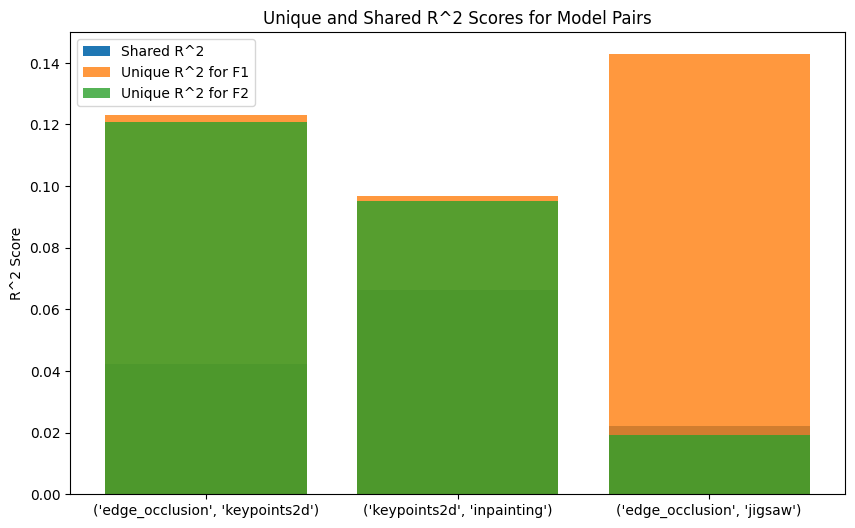

In [151]:
import matplotlib.pyplot as plt

# Plotting the results
pairs = list(unique_shared_r2.keys())
unique_r2_scores = [values[0:2] for values in unique_shared_r2.values()]
shared_r2_scores = [values[2] for values in unique_shared_r2.values()]
asym_scores = list(asymmetric_measures.values())

x = range(len(pairs))

plt.figure(figsize=(10, 6))
plt.bar(x, shared_r2_scores, label='Shared R^2')
plt.bar(x, [score[0] for score in unique_r2_scores], label='Unique R^2 for F1', alpha=0.8)
plt.bar(x, [score[1] for score in unique_r2_scores], label='Unique R^2 for F2', alpha=0.8)
plt.xticks(x, pairs)
plt.ylabel('R^2 Score')
plt.title('Unique and Shared R^2 Scores for Model Pairs')
plt.legend()

plt.show()

## **References**

- https://www.cs.cmu.edu/~neural-taskonomy/
- http://taskonomy.stanford.edu/
- https://bold5000-dataset.github.io/website/download.html
- https://github.com/alexsax/midlevel-reps/blob/master/README.md#installing-visualpriors
- https://github.com/ariaaay/NeuralTaskonomy/blob/master/code/make_task_tree.py